Mounted at /content/drive
Labels loaded:
    image_name       food_name  calories  weight_grams
0  chedder.png  Cheddar cheese       200          51.0
1    gouda.png    Gouda cheese       300          84.0
2      Avo.png         Avocado       200         125.0
3     Kiwi.png            Kiwi       200         328.0
4     rice.png      Brown rice       420         297.7

Class Distribution:
 food_name
Cheddar cheese    1
Gouda cheese      1
Avocado           1
Kiwi              1
Brown rice        1
Red onion         1
Potato            1
Cheeseburger      1
Hot dog           1
Tuna Sub          1
Name: count, dtype: int64
Predicted Food: Red onion
Calories: 200 kcal


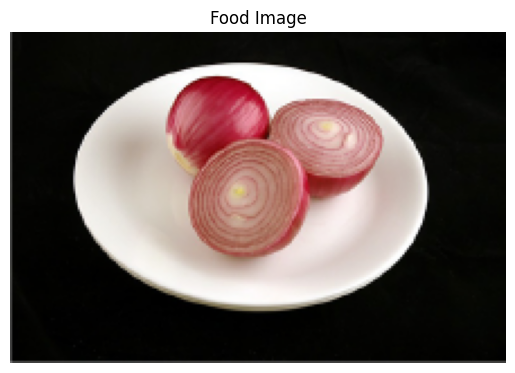

Predicted Food: Avocado
Calories: 200 kcal


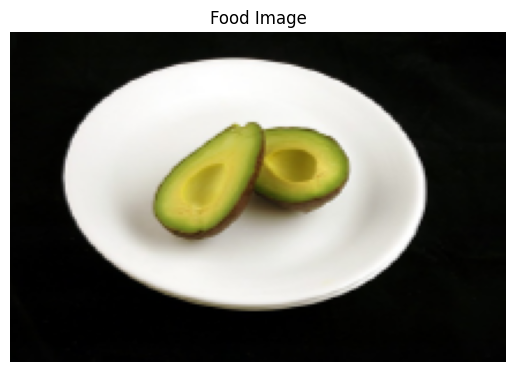

Predicted Food: Cheddar cheese
Calories: 200 kcal


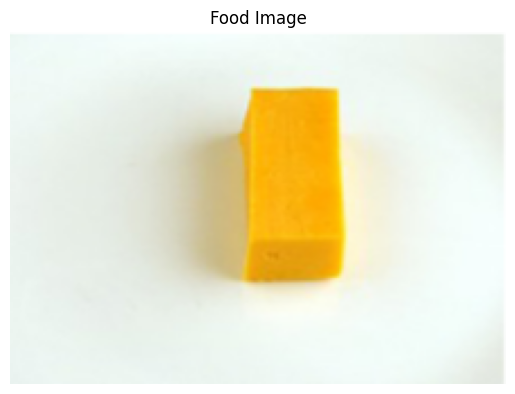

Predicted Food: Gouda cheese
Calories: 300 kcal


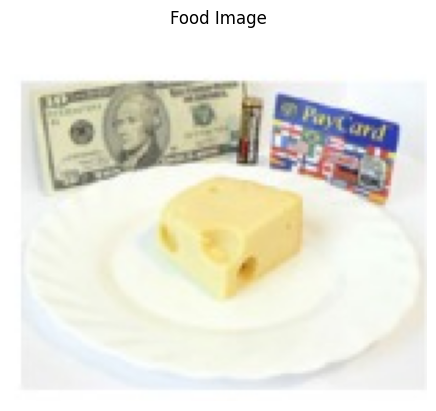

Predicted Food: Tuna Sub
Calories: 720 kcal


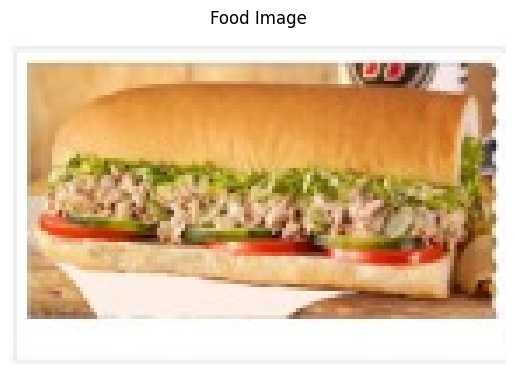

Predicted Food: Kiwi
Calories: 200 kcal


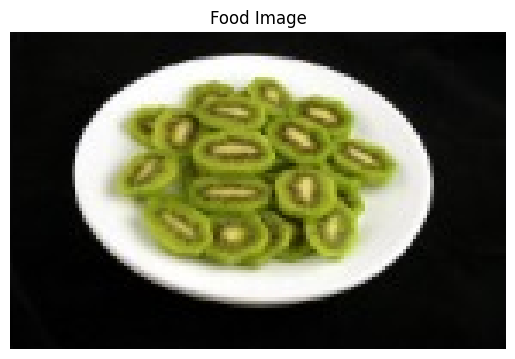

Predicted Food: Cheeseburger
Calories: 270 kcal


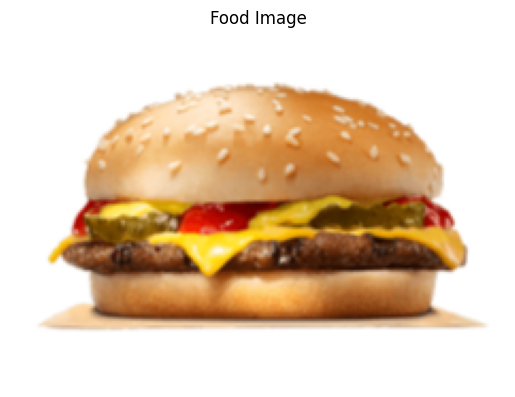

Predicted Food: Brown rice
Calories: 420 kcal


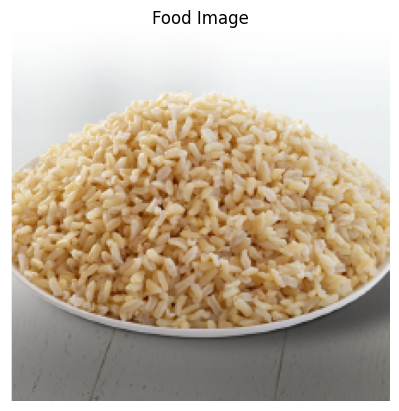

Predicted Food: Cheddar cheese
Calories: 200 kcal


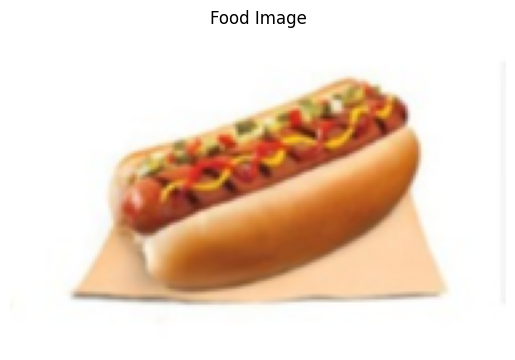

Predicted Food: Potato
Calories: 100 kcal


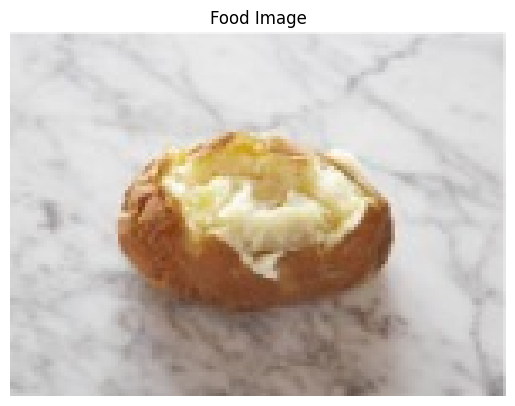

Accuracy: 90.0 %
Correct Predictions: ['Red onion', 'Avocado', 'Cheddar cheese', 'Gouda cheese', 'Tuna Sub', 'Kiwi', 'Cheeseburger', 'Brown rice', 'Potato']


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from skimage.color import rgb2gray


drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Food'
images_path = os.path.join(dataset_path, 'Images')
labels_path = os.path.join(dataset_path, 'labels.csv')
labels_df = pd.read_csv(labels_path)
print("Labels loaded:")
print(labels_df.head())
calorie_map = labels_df.set_index('food_name')['calories'].to_dict()


class_counts = labels_df['food_name'].value_counts()
print("\nClass Distribution:\n", class_counts)

def show_image(title, image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV color space
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_features(image):
    features = {}

    #shape
    edges = cv2.Canny(image, threshold1=100, threshold2=200)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        features['shape_area'] = cv2.contourArea(largest_contour)
    else:
        features['shape_area'] = 0

    mean_color = cv2.mean(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    features['mean_r'] = mean_color[0]
    features['mean_g'] = mean_color[1]
    features['mean_b'] = mean_color[2]
    features['texture_std'] = np.std(image)


    hist = extract_color_histogram(image)
    for i, val in enumerate(hist):
        features[f'hist_{i}'] = val

    return features


def segment_food(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(mask)

        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image


features_list = []
image_labels = []

for _, row in labels_df.iterrows():
    image_name = row['image_name']
    food_name = row['food_name']
    image_path = os.path.join(images_path, image_name)


    image = cv2.imread(image_path)
    if image is not None:

        segmented_image = segment_food(image)


        features = extract_features(segmented_image)
        features_list.append(features)
        image_labels.append(food_name)


features_df = pd.DataFrame(features_list)
features_df['label'] = image_labels


X = features_df.drop('label', axis=1)
y = features_df['label']

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

labels_encoder = LabelEncoder()
labels_encoder.fit(y)
y_train_encoded = labels_encoder.transform(y_train)
try:
    y_test_encoded = labels_encoder.transform(y_test)
except ValueError as e:
    unseen_labels = set(y_test) - set(labels_encoder.classes_)
    print("Unseen labels in test set:", unseen_labels)
    raise



random_seed = 42
classifier = LinearSVC(random_state=random_seed, max_iter=1000, class_weight='balanced')
classifier.fit(X_train_scaled, y_train_encoded)
accuracy = classifier.score(X_test_scaled, y_test_encoded)
y_pred = classifier.predict(X_test_scaled)
unique_test_classes = np.unique(y_test_encoded)
target_names = labels_encoder.inverse_transform(unique_test_classes)


# Predict the food type of a test image
def predict_food(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        segmented_image = segment_food(image)
        features = extract_features(segmented_image)
        features_df = pd.DataFrame([features])
        features_scaled = scaler.transform(features_df)
        predicted_label_encoded = classifier.predict(features_scaled)[0]
        predicted_label = labels_encoder.inverse_transform([predicted_label_encoded])[0]
        return predicted_label
    else:
        return "Image not found"


# Corrected prediction comparison
all_images = ['onion', 'Avo','chedder','gouda','tuna','Kiwi','Burger','rice','hotdog','Potato']
correct_predictions = []  # List to store correct food predictions
count_of_correct_predictions = 0

for image_name in all_images:
    test_image_path = os.path.join(images_path, f'{image_name}.png')

    # Read image
    image = cv2.imread(test_image_path)

    if image is not None:
        segmented_image = segment_food(image)
        predicted_food_name = predict_food(test_image_path)


        actual_food_name = labels_df[labels_df['image_name'] == f'{image_name}.png']['food_name'].values[0]


        predicted_calories = calorie_map.get(predicted_food_name, "Unknown")

        print(f"Predicted Food: {predicted_food_name}")
        print(f"Calories: {predicted_calories} kcal")
        show_image("Food Image", image)


        if predicted_food_name.strip().lower() == actual_food_name.strip().lower():
            correct_predictions.append(predicted_food_name)
            count_of_correct_predictions += 1
    else:
        print(f"Image {image_name}.png not found.")

accuracy = count_of_correct_predictions / len(all_images)
print(f"Accuracy: {accuracy * 100} %")

print("Correct Predictions:", correct_predictions)

